## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error

## Read the data

In [2]:
## READ THE DATA 
df = pd.read_csv('../datasets/art_daily_flatmiddle.csv')

## Exploratory data analysis

In [3]:
# Getting descriptive statistics
print('Descriptive statistics:')
print(df.describe(include='all').T)

Descriptive statistics:
            count unique                  top freq       mean        std  \
timestamp    4032   4032  2014-04-01 00:00:00    1        NaN        NaN   
value      4032.0    NaN                  NaN  NaN  18.981142  45.374171   

                 min        25%        50%        75%        max  
timestamp        NaN        NaN        NaN        NaN        NaN  
value     -21.998789 -19.929162 -17.541296  74.425223  87.958348  


In [4]:
# Missing value analysis
print("Missing value analysis:")
print(df[df.isna().any(axis=1)])

Missing value analysis:
Empty DataFrame
Columns: [timestamp, value]
Index: []


In [5]:
# Set timestamp column as index for time series data
df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%Y-%m-%d %H:%M:%S')
df.set_index('timestamp', inplace = True)
print(df.dtypes)

value    float64
dtype: object


In [24]:
df

,value
timestamp,
2014-04-01 00:00:00,-21.048383
2014-04-01 00:05:00,-20.295477
2014-04-01 00:10:00,-18.127229
2014-04-01 00:15:00,-20.171665
2014-04-01 00:20:00,-21.223762
...,...
2014-04-14 23:35:00,-18.083562
2014-04-14 23:40:00,-20.278406
2014-04-14 23:45:00,-20.063239


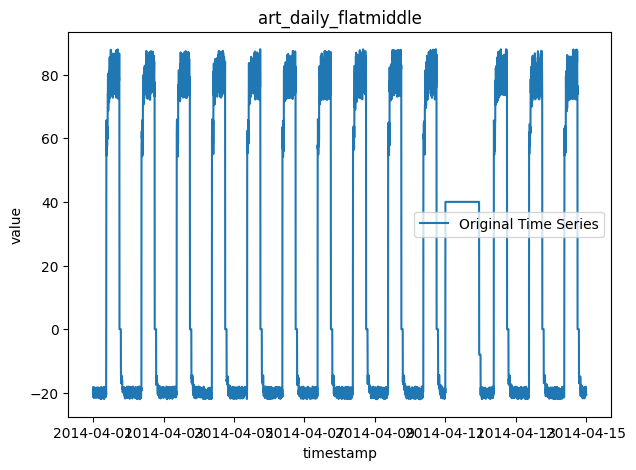

In [6]:
# Plot the original time series data
plt.figure(figsize=(7, 5))
plt.plot(df, label='Original Time Series')
plt.title('art_daily_flatmiddle')
plt.xlabel('timestamp')
plt.ylabel('value')
plt.legend()
plt.show()

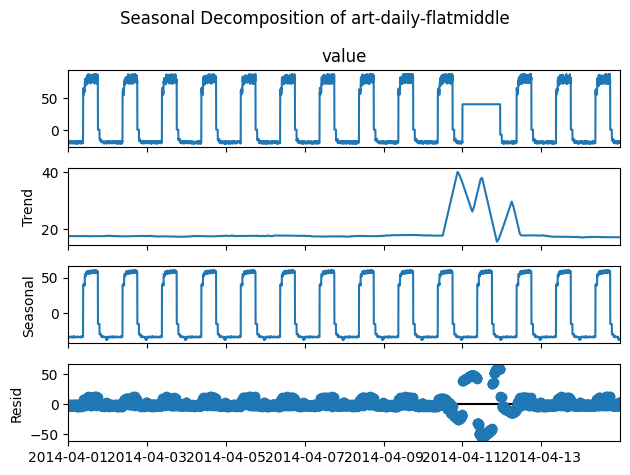

In [7]:
# Decompose the time series into trend, seasonal and residual components
df = df.asfreq('5min')
result = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq', period=288)
result.plot()
plt.suptitle('Seasonal Decomposition of art-daily-flatmiddle')
plt.tight_layout()
plt.show()

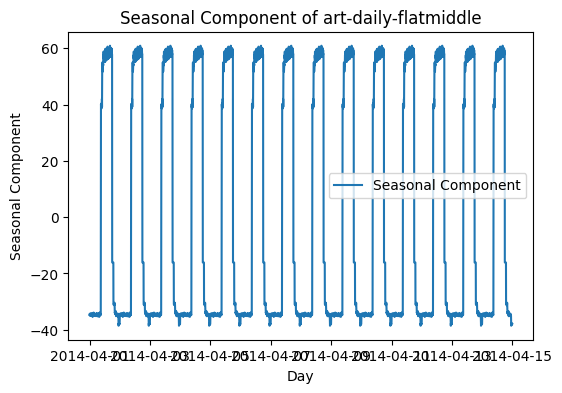

In [8]:
# Plot the seasonal component
plt.figure(figsize=(6, 4))
plt.plot(result.seasonal, label='Seasonal Component')
plt.title('Seasonal Component of art-daily-flatmiddle')
plt.xlabel('Day')
plt.ylabel('Seasonal Component')
plt.legend()
plt.show()

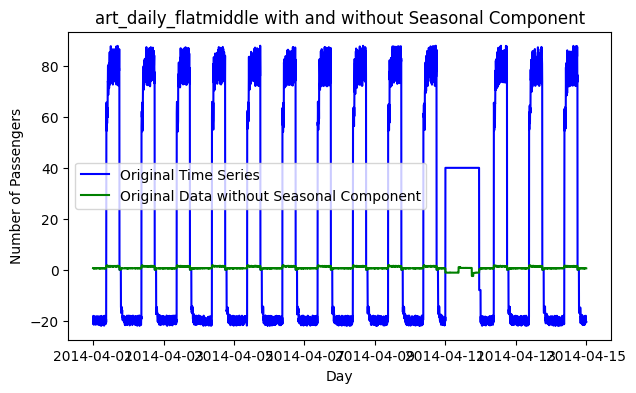

In [9]:
# Plotting the original data and original data without the seasonal component
plt.figure(figsize=(7, 4))
# Plot the original time series data
plt.plot(df, label='Original Time Series', color='blue')
data_without_seasonal = df['value'] / result.seasonal
# Plot the original data without the seasonal component
plt.plot(data_without_seasonal, label='Original Data without Seasonal Component', color='green')
plt.title('art_daily_flatmiddle with and without Seasonal Component')
plt.xlabel('Day')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

## Clean data

In [10]:
# Remove outliers using Z-scores:
z_scores = stats.zscore(df['value'].dropna())
threshold = 3
outliers = np.abs(z_scores) > threshold
cleaned_df1 = df.loc[~outliers]

print("Z-scores:", z_scores)
print("Outliers:", outliers)
print("Cleaned data:", cleaned_df1)

Z-scores: timestamp
2014-04-01 00:00:00   -0.882319
2014-04-01 00:05:00   -0.865724
2014-04-01 00:10:00   -0.817932
2014-04-01 00:15:00   -0.862995
2014-04-01 00:20:00   -0.886185
                         ...   
2014-04-14 23:35:00   -0.816969
2014-04-14 23:40:00   -0.865347
2014-04-14 23:45:00   -0.860605
2014-04-14 23:50:00   -0.875786
2014-04-14 23:55:00   -0.872275
Freq: 5min, Name: value, Length: 4032, dtype: float64
Outliers: timestamp
2014-04-01 00:00:00    False
2014-04-01 00:05:00    False
2014-04-01 00:10:00    False
2014-04-01 00:15:00    False
2014-04-01 00:20:00    False
                       ...  
2014-04-14 23:35:00    False
2014-04-14 23:40:00    False
2014-04-14 23:45:00    False
2014-04-14 23:50:00    False
2014-04-14 23:55:00    False
Freq: 5min, Name: value, Length: 4032, dtype: bool
Cleaned data:                          value
timestamp                     
2014-04-01 00:00:00 -21.048383
2014-04-01 00:05:00 -20.295477
2014-04-01 00:10:00 -18.127229
2014-04-01 00:1

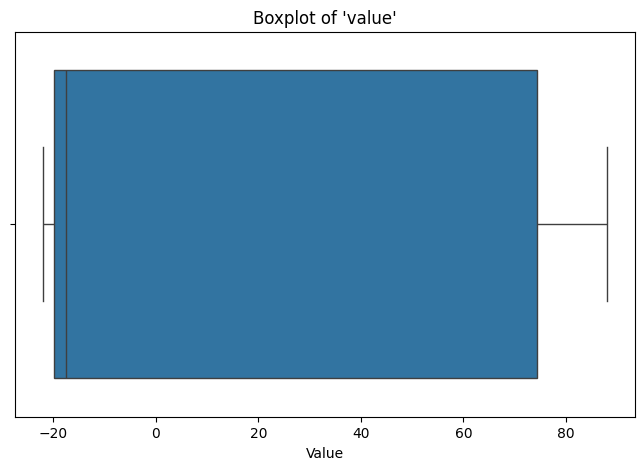

Data after removing outliers:
                         value
timestamp                     
2014-04-01 00:00:00 -21.048383
2014-04-01 00:05:00 -20.295477
2014-04-01 00:10:00 -18.127229
2014-04-01 00:15:00 -20.171665
2014-04-01 00:20:00 -21.223762
...                        ...
2014-04-14 23:35:00 -18.083562
2014-04-14 23:40:00 -20.278406
2014-04-14 23:45:00 -20.063239
2014-04-14 23:50:00 -20.751973
2014-04-14 23:55:00 -20.592696

[4032 rows x 1 columns]


In [11]:
# Using Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['value'].dropna())
plt.title("Boxplot of 'value'")
plt.xlabel('Value')
plt.show()

# Clean df
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
cleaned_df2 = df[(df['value'] >= lower_bound) & (df['value'] <= upper_bound)]

print("Data after removing outliers:")
print(cleaned_df2)

## Forecast

### Check stationarity and variance

In [12]:
# ADF test
adf_result = adfuller(df)
print(adf_result[1])

3.4499168578813477e-07


In [13]:
# KPSS test
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(df)
print(kpss_result[1])

0.1


C:\Users\vanng\AppData\Local\Temp\ipykernel_15748\1420963488.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df)


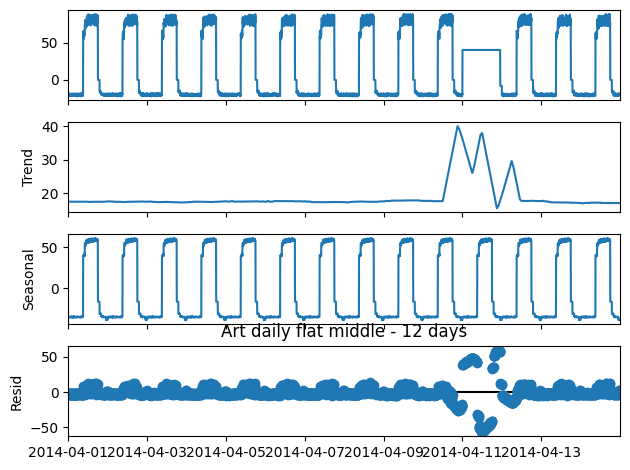

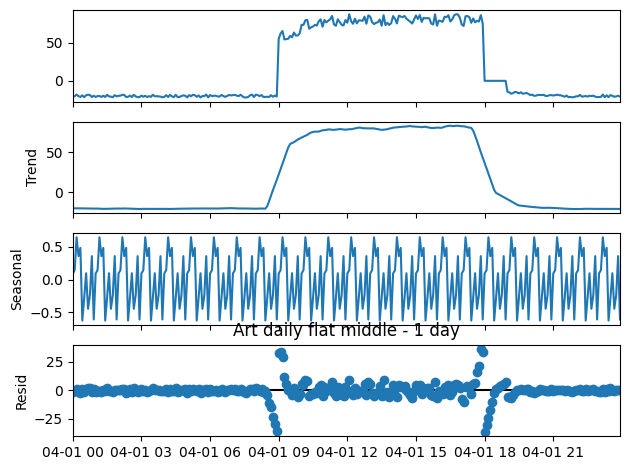

In [14]:
# Interpreting both ADF and PKSS test

result = seasonal_decompose(df, model='additive', extrapolate_trend='freq', period=288)
result.plot()
plt.title("Art daily flat middle - 12 days")
plt.show()

# use on a subset of data to see the dataset more clearly
# choose the first 48 months
result = seasonal_decompose(df[:288], model='additive', extrapolate_trend='freq', period=12)
result.plot()
plt.title("Art daily flat middle - 1 day")
plt.show()

### Plot auto-correlation

In [15]:
import sktime
from sktime.split import temporal_train_test_split

In [16]:
from sktime.split import temporal_train_test_split
train, test = temporal_train_test_split(df, test_size=36)

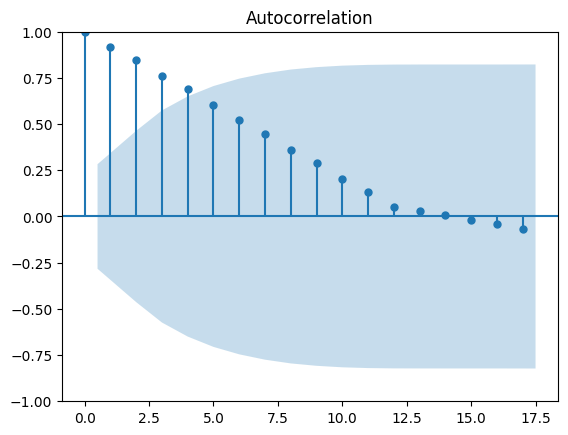

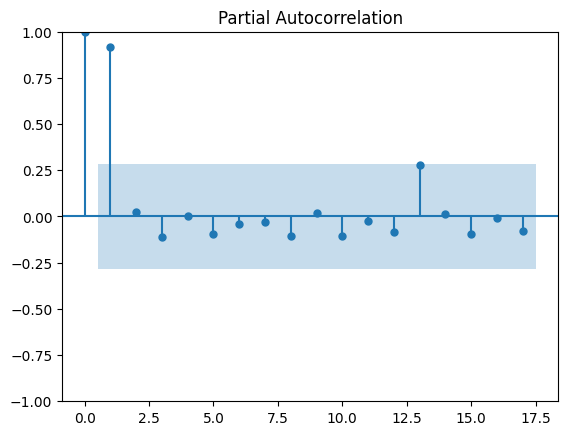

In [17]:
# PLot PACF

plot_acf(train[-48:])
plt.show()

plot_pacf(train[-48:])
plt.show()

## Train the ARIMA model

### First training

In [18]:
model = ARIMA(train, order=(2,0,0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 3996
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -13788.018
Date:                Thu, 14 Nov 2024   AIC                          27584.037
Time:                        20:29:46   BIC                          27609.209
Sample:                    04-01-2014   HQIC                         27592.960
                         - 04-14-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.3318     12.127      1.594      0.111      -4.437      43.100
ar.L1          0.8722      0.012     72.218      0.000       0.849       0.896
ar.L2          0.1151      0.012      9.920      0.0

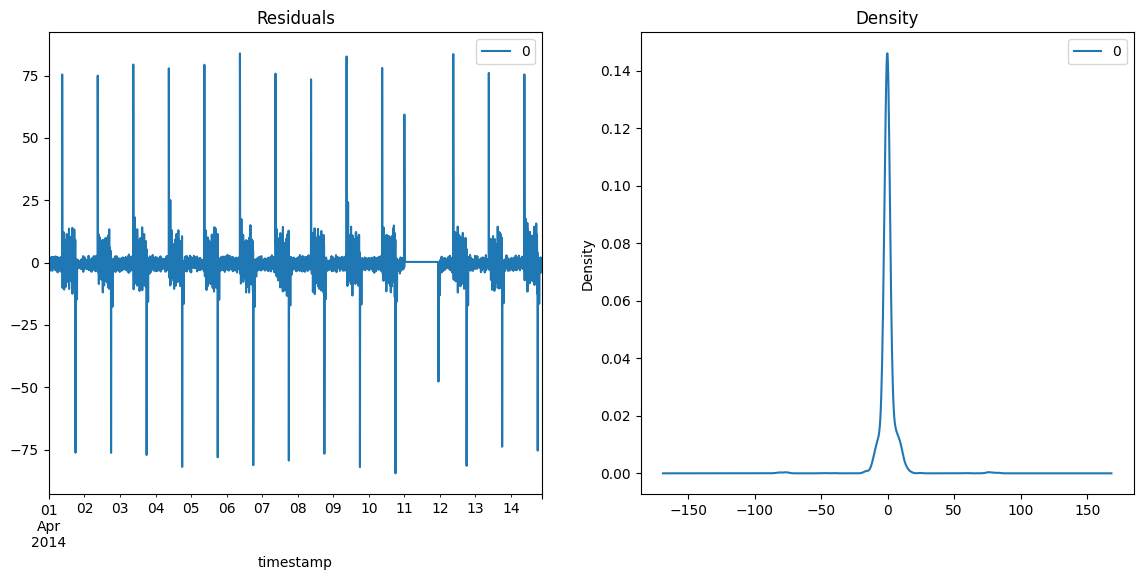

In [19]:
# density plot of residuals
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

C:\Users\vanng\AppData\Local\Temp\ipykernel_15748\342013993.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'predictions'] = predictions.copy()


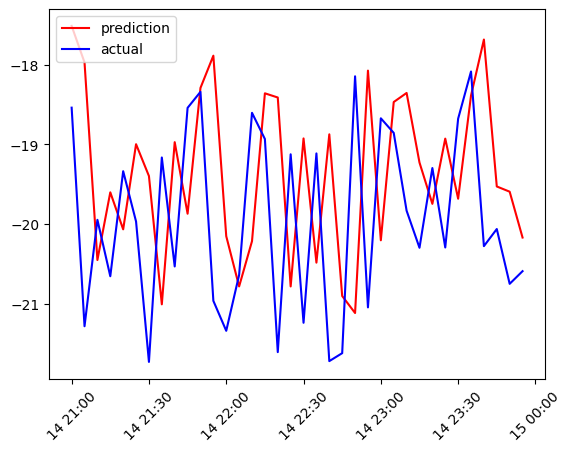

In [20]:
history = train
predictions = list()
# walk-forward validation
for t in range(len(test),0,-1):
    model = ARIMA(df[:-t], order=(2,0,0));
    model_fit = model.fit();
    output = model_fit.forecast();
    yhat = output.iloc[0]
    predictions.append(yhat)
    
    
test.loc[:,'predictions'] = predictions.copy()

plt.plot(test['predictions'], color='red', label='prediction')
plt.plot(test['value'], color='blue', label='actual')
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()


In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate forecasts
rmse = sqrt(mean_squared_error(test['predictions'], test['value']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.716


### Second training

In [ ]:
import pmdarima as pm

auto_model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      m=24, # frequency of series
                      d=None, # let model determine 'd'
                      seasonal=True, # Use Seasonality
                      information_criterion='aicc',
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
                      
print(auto_model.summary())

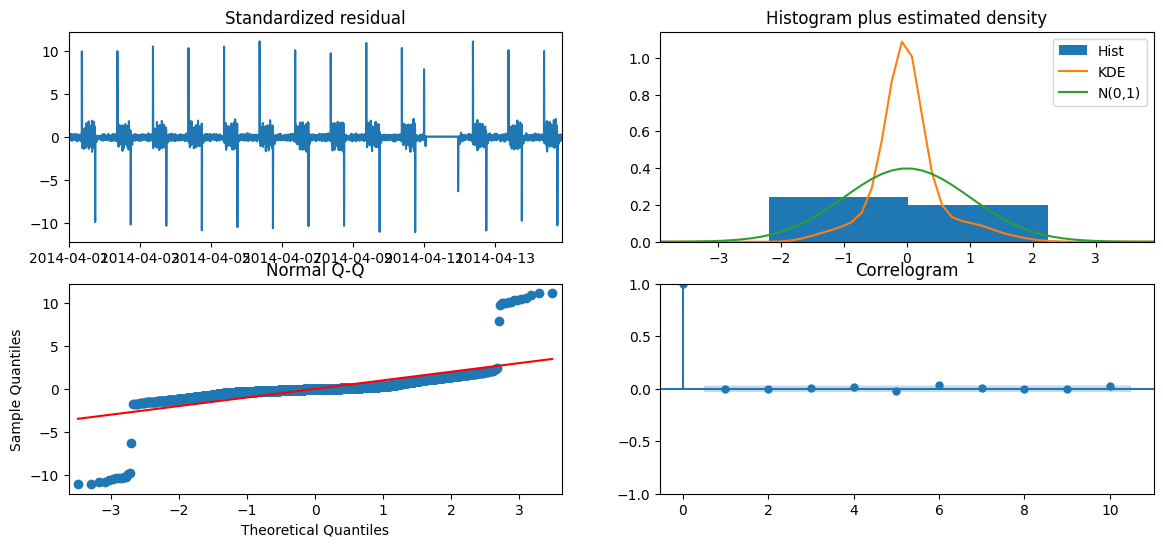

In [ ]:
auto_model.plot_diagnostics(figsize=(14, 6))
plt.show()

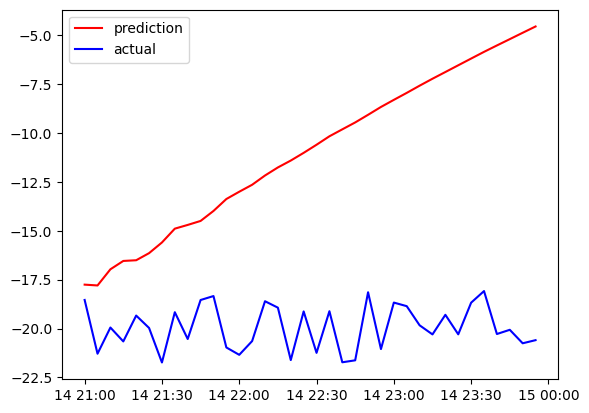

In [ ]:
history = train
auto_predictions = auto_model.predict(len(test))

# Graph the prediction
test.loc[:, 'auto_predictions'] = auto_predictions.copy()

plt.plot(test['auto_predictions'], color='red', label='prediction')
plt.plot(test['value'], color='blue', label='actual')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test['auto_predictions'], test['value']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 9.859
